In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import cv2
from scipy.spatial import distance

**MASK DETECTİON**

Merhaba!

Yeniden Tam kapanmaya(!) girdiğimiz bu günlerde günün anlam ve önemine istinaden aklıma maske detektörü yapma fikri geldi.

Kaggle'da buna benzer bir çok çalışmanın mevcut olduğunu gördüm içlerinden bazıları gerçekten çok başarılıydı, bu çalışmada da yine birçok örnekte olduğu gibi maske takan ve maske takmayan insanları birbirlerinden ayırt etmeye çalışacağım.

Bunun için kaggle üzerinden önce maske takan insanların olduğu bir data seti aradım. Maske takan insanlar için kullandığım data seti "face-mask-12k-images-dataset" oldu fakat buradak data setinden yalnızca train ve maskeli olan fotoğrafları aldım. Maskesiz insanlar için ise "human-faces" isimli data setini kullandım. Aslında sadece "face-mask-12k-images-dataset" içinde hem maskeli hemde maskesiz insan fotoğrafları vardı ama maskesiz fotoğrafları çok beğenmedim (aslında maskelilerde pek güzel değildi ama neticede maskeli :) ) bu yüzden iki farklı data kullanmak istedim.

Dataları almak için pathleri oluşturdum ardından maskeli ve maskesiz fotoğraflar için data frameleri birleştirdim.

In [11]:
mask_path = "Face Mask Dataset/WithMask"
no_mask_path = "Face Mask Dataset/WithoutMask"

In [12]:
image_mask = []
target_mask = []
for i in os.listdir(mask_path):
    pic = os.path.join(mask_path + "/", i)
    image_mask.append(pic)
    target_mask.append("mask")   

image_no_mask = []
target_no_mask = []
for i in os.listdir(no_mask_path):
    pic = os.path.join(no_mask_path + "/", i)
    image_no_mask.append(pic)
    target_no_mask.append("without_mask")

mask = pd.DataFrame()
mask["image"] = image_mask
mask["target"] = target_mask

no_mask = pd.DataFrame()
no_mask["image"] = image_no_mask
no_mask["target"] = target_no_mask

data = pd.concat([mask, no_mask], axis = 0, ignore_index = True)
data = shuffle(data)
data

,image,target
1818,Face Mask Dataset/WithMask/Augmented_249_27892...,mask
8639,Face Mask Dataset/WithoutMask/3515.png,without_mask
2173,Face Mask Dataset/WithMask/Augmented_305_24323...,mask
6364,Face Mask Dataset/WithoutMask/1444.png,without_mask
8092,Face Mask Dataset/WithoutMask/3015.png,without_mask
...,...,...
8425,Face Mask Dataset/WithoutMask/3319.png,without_mask
3094,Face Mask Dataset/WithMask/Augmented_455_12015...,mask
10222,Face Mask Dataset/WithoutMask/4968.png,without_mask
3368,Face Mask Dataset/WithMask/Augmented_499_17187...,mask


Datadaki maskeli ve maskesiz fotoğrafların dağılımları aşağıdaki gibidir. Maskesiz insan fotoğrafları biraz daha yüksek olsada veride aşırı bir dengesizlik bulunmamaktadır.

C:\Users\smistry\Documents\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

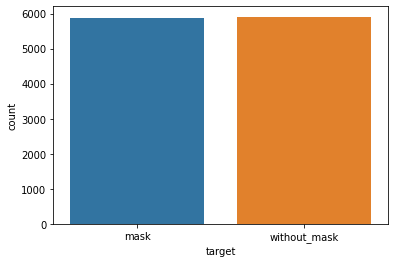

In [13]:
sns.countplot(data["target"])

Maskeli ve maskesiz olan fotoğraflardan birer örneğe göz atalım.

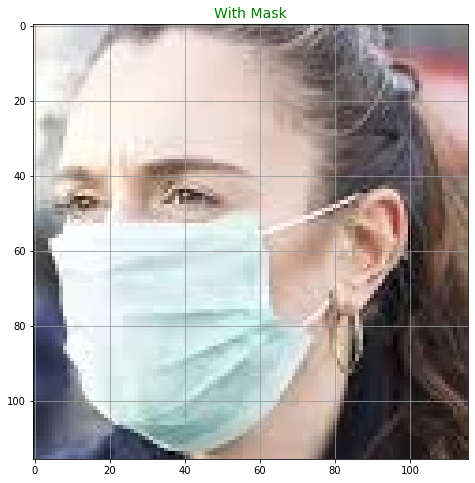

In [14]:
plt.figure(figsize=(12,8))

img = load_img(mask["image"][8])
plt.imshow(img)
plt.title("With Mask", color = "green", size = 14)
plt.grid(color='#999999', linestyle='-')
plt.show()

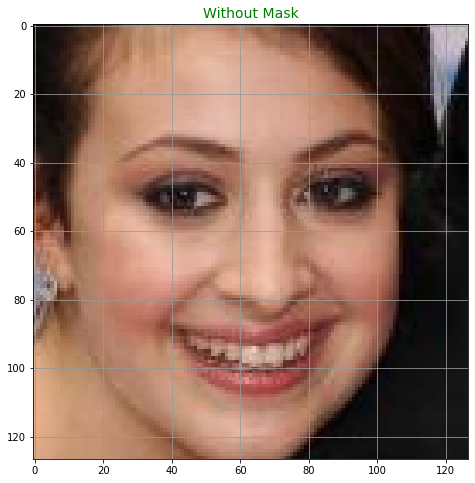

In [15]:
plt.figure(figsize=(12,8))

img = load_img(no_mask["image"][750])
plt.imshow(img)
plt.title("Without Mask", color = "green", size = 14)
plt.grid(color='#999999', linestyle='-')
plt.show()

Data hazır olduğunda data setini train, validation ve test olarak üç ayrı sete bölüyorum. 

Datayı ilk oluşturduğumda sıralı olarak almıştım fakat son aşamada shuffle yaptığım için burada iloc yardımı ile setlerimi oluşturabilirim. 

Setlerimin adetleri de yine aşağıdadır.

In [16]:
train = data.iloc[0:10000, ]
val = data.iloc[10001:11001, ]
test = data.iloc[11002:, ]

In [17]:
print("Train Seti:","\n",train["target"].value_counts(),"\n""Validation Seti: ","\n", val["target"].value_counts(), "\n"
      "Test Seti: ", "\n",test["target"].value_counts())

Train Seti: 
 without_mask    5014
mask            4986
Name: target, dtype: int64 
Validation Seti:  
 mask            501
without_mask    499
Name: target, dtype: int64 
Test Seti:  
 mask            396
without_mask    394
Name: target, dtype: int64


Setlere böldükten sonra model için resimleri düzenleme işlemine geldim.

Burada train setine data çok büyük olmadığı için çeşitlendirme uyguladım.

In [18]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = "nearest")

train_generator = train_datagen.flow_from_dataframe(dataframe = train,
                                                    x_col = "image",
                                                    y_col = "target",
                                                    target_size = (150, 150),
                                                    batch_size = 32,
                                                    class_mode = "binary")

val_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = val_datagen.flow_from_dataframe(dataframe = val,
                                                x_col = "image",
                                                y_col = "target",
                                                target_size = (150, 150),
                                                batch_size = 32,
                                                class_mode = "binary")


test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(dataframe = test,
                                                  x_col = "image",
                                                  y_col = "target",
                                                  target_size = (150, 150),
                                                  class_mode = "binary",
                                                  batch_size = 32)

Found 10000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 790 validated image filenames belonging to 2 classes.


Model kurarken yeni bir model yerine hazır eğitilmiş VGG19 modeli aldım yine ağırlıklarını imagenet olarak verdim.

In [19]:
from keras import layers
from keras import models
from keras import optimizers
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model = models.Sequential()
model.add(vgg19)
model.add(layers.Flatten())
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()

80142336/80134624 [==============================] - 15s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 8193      
Total params: 20,032,577
Trainable params: 8,193
Non-trainable params: 20,024,384
_________________________________________________________________


In [20]:
model.compile(loss = "binary_crossentropy",
             optimizer = optimizers.RMSprop(lr = 1e-4),
             metrics = ["acc"])

train ve validation setlerini eğitim için kullandım test setini evaluate yaparken kullanacağım.

In [21]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator)//32,
                    epochs=50,
                    validation_data=val_generator,
                    validation_steps=len(val_generator)//32)

Epoch 1/50
9/9 [==============================] - 28s 3s/step - loss: 0.6595 - acc: 0.5904 - val_loss: 0.5626 - val_acc: 0.8438
Epoch 2/50
9/9 [==============================] - 35s 4s/step - loss: 0.6123 - acc: 0.7082 - val_loss: 0.5821 - val_acc: 0.7812
Epoch 3/50
9/9 [==============================] - 39s 4s/step - loss: 0.5739 - acc: 0.7657 - val_loss: 0.5042 - val_acc: 0.7812
Epoch 4/50
9/9 [==============================] - 37s 4s/step - loss: 0.5440 - acc: 0.8302 - val_loss: 0.4703 - val_acc: 0.7812
Epoch 5/50
9/9 [==============================] - 40s 4s/step - loss: 0.5279 - acc: 0.8383 - val_loss: 0.4608 - val_acc: 0.7812
Epoch 6/50
9/9 [==============================] - 38s 4s/step - loss: 0.5116 - acc: 0.8005 - val_loss: 0.4406 - val_acc: 0.8750
Epoch 7/50
9/9 [==============================] - 37s 4s/step - loss: 0.5067 - acc: 0.7863 - val_loss: 0.3548 - val_acc: 0.9062
Epoch 8/50
9/9 [==============================] - 37s 4s/step - loss: 0.4797 - acc: 0.8470 - val_loss: 0

Eğitim sonuçları aşağıdaki gibi geldi.

15-20 epoktan sonra başarı iyileşmenin hızı düşmüş validasyon üzerinde ise daha fazla hareketlilik var başarı 90-95 arası gibi gözükmekte kayıplar ise 15-20 arasında

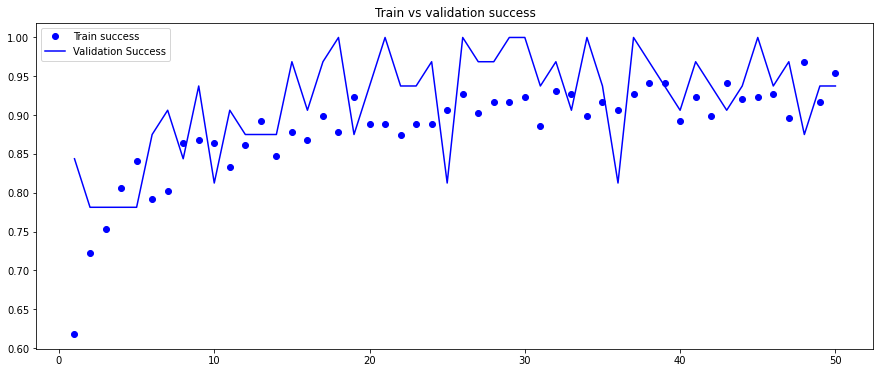

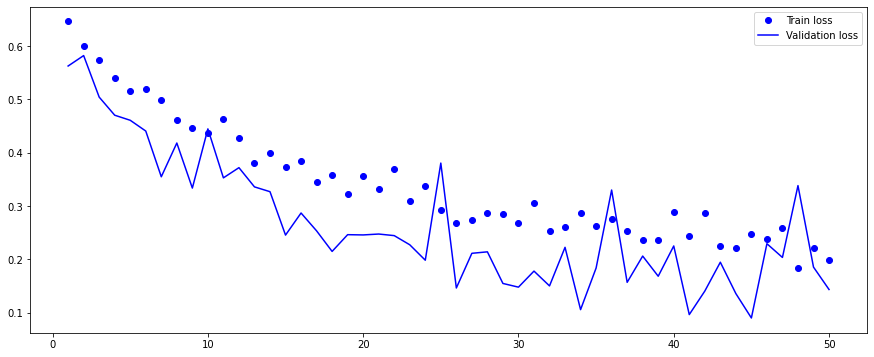

In [22]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (15, 6))

plt.plot(epochs, acc, "bo", label = "Train success")
plt.plot(epochs, val_acc, "b", label = "Validation Success")
plt.title("Train vs validation success")
plt.legend()

plt.figure(figsize = (15, 6))

plt.plot(epochs, loss, "bo", label = "Train loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.legend()

plt.show()

Modeli validation üzerinden ilk testlerini yapıldı artık test datasını kullanarak sonuçları görebiliriz.

In [23]:
test_loss, test_acc = model.evaluate(test_generator, steps = 9)
print("Test ACC: ", round(test_acc, 2))

9/9 [==============================] - 38s 4s/step - loss: 0.1433 - acc: 0.9410
Test ACC:  0.94


Test doğruluk oranı yukarıdaki çıktı.

Modeli eğitip testlerini yapıldı şimdi fotoğraflar üzerinden görsel olarak sonuçları görelim.

Bu görselleştirme işlemleri için yüz tespiti kullanılmakta buradaki yüz tespiti "haarcascades" ile hazır olarak yapıldı grafik işlemleri için [https://www.kaggle.com/nageshsingh/mask-and-social-distancing-detection-using-vgg19/data](http://) çalışmasından yararlandım güzel bir çalışma tavsiye ederim.

Önce maskeli bir fotoğraf ardında maskesiz bir fotoğraf yükledim görüntüsü aşağıda daha sonra bu görseli modele sokarak test ediliyor.

Test sonucu 0-0.5 arası gelmesi maskeli 0.5-1 arası gelmesi ise maskesiz olduğu anlamına geliyor.

Eğer bir kişi maskeli ise bize **"OK!**" cevabını döndürecek yok değil ise **"BUSTED!"** cevabını verecek.

Ve sanırım maskeli abimiz türk :) 

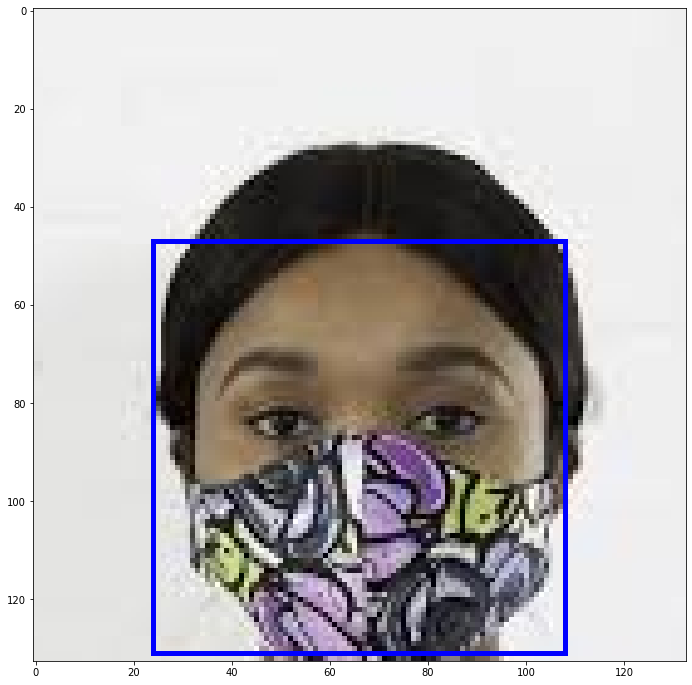

In [29]:
face_model = cv2.CascadeClassifier('haarcascade/haarcascade_frontalface_default.xml')
img = cv2.imread('Face Mask Dataset/WithMask/495.png')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img)

In [27]:
sample_mask_img = cv2.imread('Face Mask Dataset/WithMask/1058.png')
sample_mask_img = cv2.resize(sample_mask_img,(128,128))
sample_mask_img = np.reshape(sample_mask_img,[1,128,128,3])
sample_mask_img = sample_mask_img/255.0
model.predict(sample_mask_img)

array([[0.04913425]], dtype=float32)

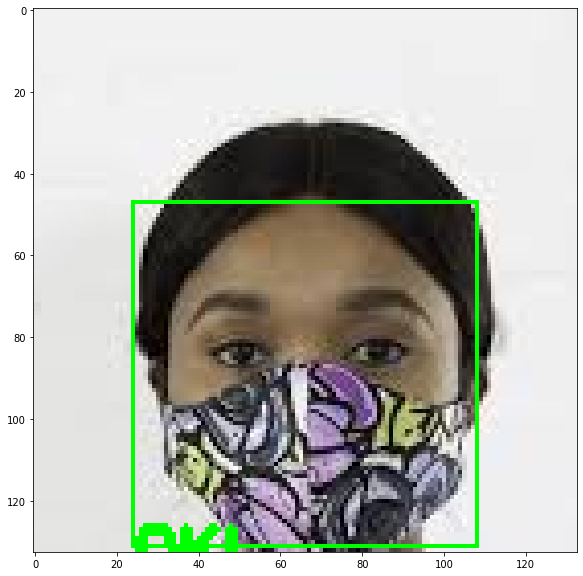

In [30]:
mask_label = {0:'OK!',1:'Busted'}
dist_label = {0:(0,255,0),1:(255,0,0)}
MIN_DISTANCE = 0

if len(faces)>=1:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(new_img,mask_label[round(mask_result[0][0])],(x, y+90), cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No face!")

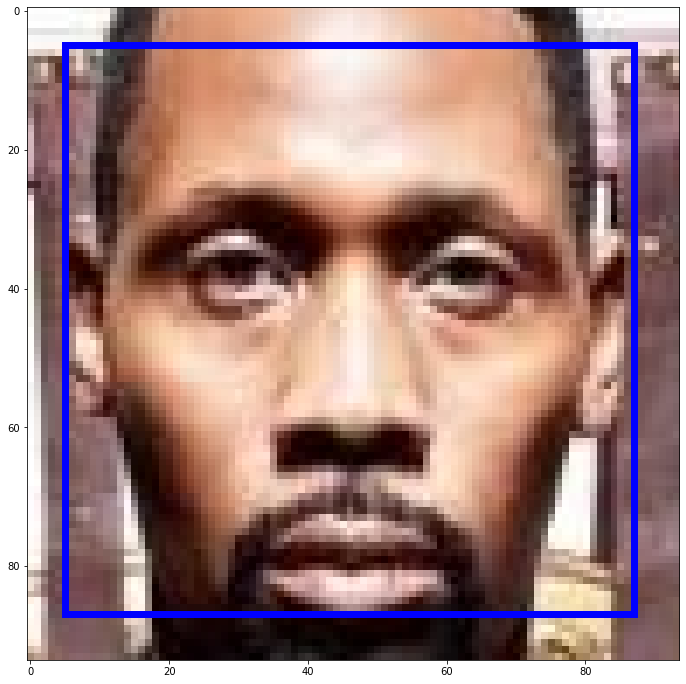

In [31]:
img = cv2.imread('Face Mask Dataset/WithoutMask/2.png')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 

for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img)

In [47]:
sample_mask_img = cv2.imread('Face Mask Dataset/WithoutMask/2.png')
sample_mask_img = cv2.resize(sample_mask_img,(128,128))
sample_mask_img = np.reshape(sample_mask_img,[1,128,128,3])
sample_mask_img = sample_mask_img/255.0
prediction = model.predict(sample_mask_img)

In [48]:
if prediction[0][0]<0.5:
    print("Mask")
else:
    print("No mask")

No mask


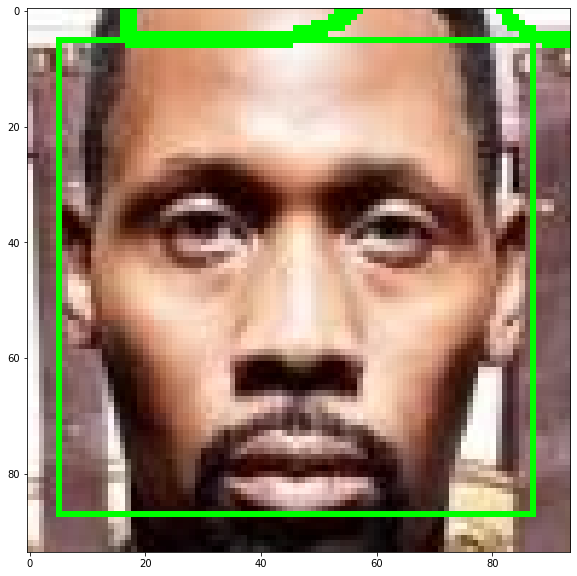

In [33]:
if len(faces)>=1:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(new_img,mask_label[round(mask_result[0][0])],(x, y), cv2.FONT_HERSHEY_SIMPLEX,3,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No face!")

Umarım çalışma sizler için faydalı olmuştur, en kısa sürede tam normal olarak görüşmek üzere :)

#MaskeTak

In [37]:
from keras import models

models.save_model(model,'model.h5')